In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pathlib import Path
import pickle
from collections import OrderedDict
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from mlxtend.plotting import plot_confusion_matrix

import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from IPython.display import HTML
plt.style.use('seaborn-dark')
theano.config.compute_test_value = 'raise'  # funny bug when first making a theano variable

In [ ]:
columns=["age","sex","chest_pain_type","resting_blood_pressure","serum_cholesterol","fasting_blood_sugar","resting_electrocardiographic_results","maximum_heart_rate","exercise_induced_angina","oldpeak","slope","number_major_vessels","thal","target"]

In [ ]:
with open('heart.dat') as f:
    heart_data=f.readlines()
def data_preprocessing(data):
    data_list=[]
    for i in data:
        observation=i.strip("\n").split()
        for j in range(len(observation)):
            observation[j]=float(observation[j])
        data_list.append(observation)
    return np.array(data_list)
# We just preprocess the data 
heart_data=data_preprocessing(heart_data)
full_heart_data=[]
for i in range(14):
    imputed=np.nan_to_num(heart_data[:,i],nan=np.mean(heart_data[:,i]))
    full_heart_data.append(list(imputed))
full_heart_data=np.array(full_heart_data).transpose()
def convert_label(x):
    if x==2:
        return 1
    else:
        return 0
data=pd.DataFrame(full_heart_data,columns=columns)
data["target"]=data["target"].apply(convert_label)

In [ ]:
data

age  sex  chest_pain_type  ...  number_major_vessels  thal  target
0    70.0  1.0              4.0  ...                   3.0   3.0       1
1    67.0  0.0              3.0  ...                   0.0   7.0       0
2    57.0  1.0              2.0  ...                   0.0   7.0       1
3    64.0  1.0              4.0  ...                   1.0   7.0       0
4    74.0  0.0              2.0  ...                   1.0   3.0       0
..    ...  ...              ...  ...                   ...   ...     ...
265  52.0  1.0              3.0  ...                   0.0   7.0       0
266  44.0  1.0              2.0  ...                   0.0   7.0       0
267  56.0  0.0              2.0  ...                   0.0   3.0       0
268  57.0  1.0              4.0  ...                   0.0   6.0       0
269  67.0  1.0              4.0  ...                   3.0   3.0       1

[270 rows x 14 columns]

In [ ]:
full_model="target~age+sex+chest_pain_type+resting_blood_pressure+serum_cholesterol+fasting_blood_sugar+resting_electrocardiographic_results+maximum_heart_rate+exercise_induced_angina+oldpeak+slope+number_major_vessels+thal"

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


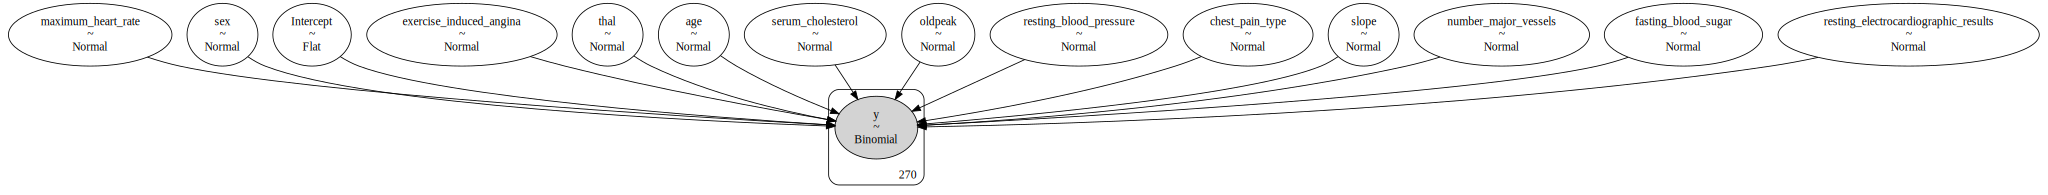

In [ ]:
pm.model_to_graphviz(logistic_model)

In [ ]:
with logistic_model:
    trace = pm.sample(tune=2000,
                         draws=2000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=3)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [thal, number_major_vessels, slope, oldpeak, exercise_induced_angina, maximum_heart_rate, resting_electrocardiographic_results, fasting_blood_sugar, serum_cholesterol, resting_blood_pressure, chest_pain_type, sex, age, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 163 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  ...  ess_tail  r_hat
Intercept                            -9.310  3.289  ...    3735.0    1.0
age                                  -0.020  0.027  ...    4883.0    1.0
sex                                   1.688  0.568  ...    4837.0    1.0
chest_pain_type                       0.780  0.229  ...    4183.0    1.0
resting_blood_pressure                0.028  0.012  ...    4677.0    1.0
serum_cholesterol                     0.008  0.004  ...    5071.0    1.0
fasting_blood_sugar                  -0.876  0.592  ...    5190.0    1.0
resting_electrocardiographic_results  0.337  0.207  ...    5346.0    1.0
maximum_heart_rate                   -0.023  0.011  ...    4865.0    1.0
exercise_induced_angina               0.902  0.461  ...    5137.0    1.0
oldpeak                               0.378  0.237  ...    5155.0    1.0
slope                                 0.478  0.410  ...    5680.0    1.0
number_major_vessels                  1.284  0.284  ...    5270.0    1.0
thal                                  0.375  0.108  ...    5065.0    1.0

[14 rows x 9 columns]

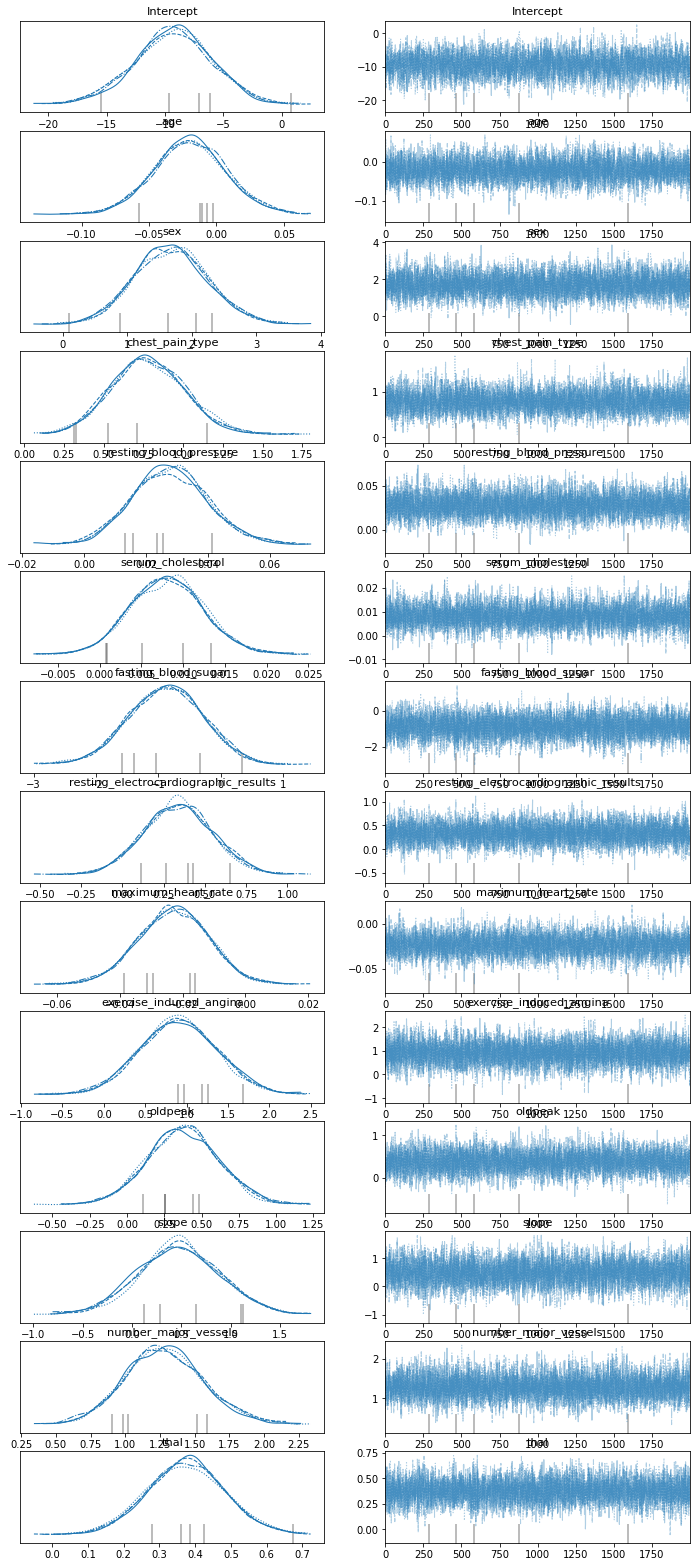

In [ ]:
parameters=None
with logistic_model:
    pm.plot_trace(trace)
    display(pm.summary(trace))
    parameters=pm.summary(trace)["mean"]

In [ ]:
parameters[0:15]

Intercept                              -9.310
age                                    -0.020
sex                                     1.688
chest_pain_type                         0.780
resting_blood_pressure                  0.028
serum_cholesterol                       0.008
fasting_blood_sugar                    -0.876
resting_electrocardiographic_results    0.337
maximum_heart_rate                     -0.023
exercise_induced_angina                 0.902
oldpeak                                 0.378
slope                                   0.478
number_major_vessels                    1.284
thal                                    0.375
Name: mean, dtype: float64

In [ ]:
parameter_2=None
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute',tolerance=2e-4)
    approx = pm.fit(n=10000, callbacks=[callback], obj_n_mc=10,
               obj_optimizer=pm.adagrad(learning_rate=0.2))

Finished [100%]: Average Loss = 249.9


In [ ]:
with logistic_model:  
    trace_advi = approx.sample(5000)
    display(pm.summary(trace_advi))
    parameter_2=pm.summary(trace_advi)["mean"]

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


mean     sd  ...  ess_tail  r_hat
Intercept                            -1.612  0.259  ...    4586.0    NaN
age                                  -0.074  0.008  ...    4741.0    NaN
sex                                   1.825  0.270  ...    5071.0    NaN
chest_pain_type                       0.797  0.081  ...    5100.0    NaN
resting_blood_pressure                0.023  0.004  ...    4905.0    NaN
serum_cholesterol                     0.007  0.003  ...    4895.0    NaN
fasting_blood_sugar                  -0.834  0.574  ...    4638.0    NaN
resting_electrocardiographic_results  0.423  0.162  ...    4899.0    NaN
maximum_heart_rate                   -0.054  0.005  ...    4183.0    NaN
exercise_induced_angina               1.063  0.413  ...    4635.0    NaN
oldpeak                               0.522  0.166  ...    3556.0    NaN
slope                                 0.249  0.147  ...    4856.0    NaN
number_major_vessels                  1.683  0.239  ...    4942.0    NaN
thal                                  0.477  0.054  ...    4665.0    NaN

[14 rows x 9 columns]

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


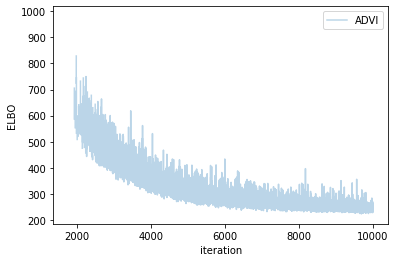

In [ ]:
with logistic_model:
  plt.plot(approx.hist, label="ADVI", alpha=0.3)
  plt.legend()
  plt.ylabel("ELBO")
  plt.xlabel("iteration")

In [ ]:
parameter_2[:15]

Intercept                              -1.612
age                                    -0.074
sex                                     1.825
chest_pain_type                         0.797
resting_blood_pressure                  0.023
serum_cholesterol                       0.007
fasting_blood_sugar                    -0.834
resting_electrocardiographic_results    0.423
maximum_heart_rate                     -0.054
exercise_induced_angina                 1.063
oldpeak                                 0.522
slope                                   0.249
number_major_vessels                    1.683
thal                                    0.477
Name: mean, dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
Y=data["target"]

In [ ]:
X=data.drop("target",axis=1)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X, Y)

In [ ]:
pd.Series(clf.coef_[0])

0    -0.051663
1     0.478940
2     0.525379
3     0.013107
4     0.003898
5    -0.108423
6     0.313150
7    -0.037643
8     0.414760
9     0.395172
10    0.034271
11    1.129066
12    0.427699
dtype: float64

In [ ]:
clf.intercept_

array([-0.06040637])

In [ ]:
pred=clf.predict(X)

In [ ]:
np.mean(pred==Y)

0.8555555555555555

In [ ]:
def prediction_and_evaluation(parameters,X,Y):
  parameters=list(parameters)
  intercept=parameters[0]
  betas=np.array(parameters[1:14])
  out=[]
  data=np.array(X)
  for i in range(data.shape[0]):
    feature_vector=data[i]
    result=betas.dot(feature_vector)+intercept
    logit= 1/(1+np.exp(-result))
    out.append(logit)
  def prediction(x):
    if x<0.5:
      return 0
    else:
      return 1
  predict=np.array(pd.Series(out).apply(prediction))
  labels=np.array(Y)
  return np.mean(predict==labels)


In [ ]:
# accuracy of MCMC
prediction_and_evaluation(parameters,X,Y)

0.8555555555555555

One interesting finding: sometimes the accuracy evaluated by ADVI is better than the one evaluated by MCMC or MLE. But given the fact that we only sample 2000 times (exlude from the burn-in rate,which means those samples are effective) in MCMC. Had we sample more, the accuracy achived by MCMC could be higher than which was done by ADVI, but at cost of much longer running time.

A improved traning strategy based on this finding: Instead of using MCMC to estimate the parameters of the model, which takes longer time,
one can fit the model using ADVI many times and records the parameters. Then, we can pick the one with highest performance. The 

In [ ]:
# accuracy of advi 
prediction_and_evaluation(parameter_2,X,Y)

0.8592592592592593

In [ ]:
pd.Series(clf.coef_[0])

0    -0.051663
1     0.478940
2     0.525379
3     0.013107
4     0.003898
5    -0.108423
6     0.313150
7    -0.037643
8     0.414760
9     0.395172
10    0.034271
11    1.129066
12    0.427699
dtype: float64

In [ ]:
parameters[1:14]

age                                    -0.020
sex                                     1.688
chest_pain_type                         0.780
resting_blood_pressure                  0.028
serum_cholesterol                       0.008
fasting_blood_sugar                    -0.876
resting_electrocardiographic_results    0.337
maximum_heart_rate                     -0.023
exercise_induced_angina                 0.902
oldpeak                                 0.378
slope                                   0.478
number_major_vessels                    1.284
thal                                    0.375
Name: mean, dtype: float64

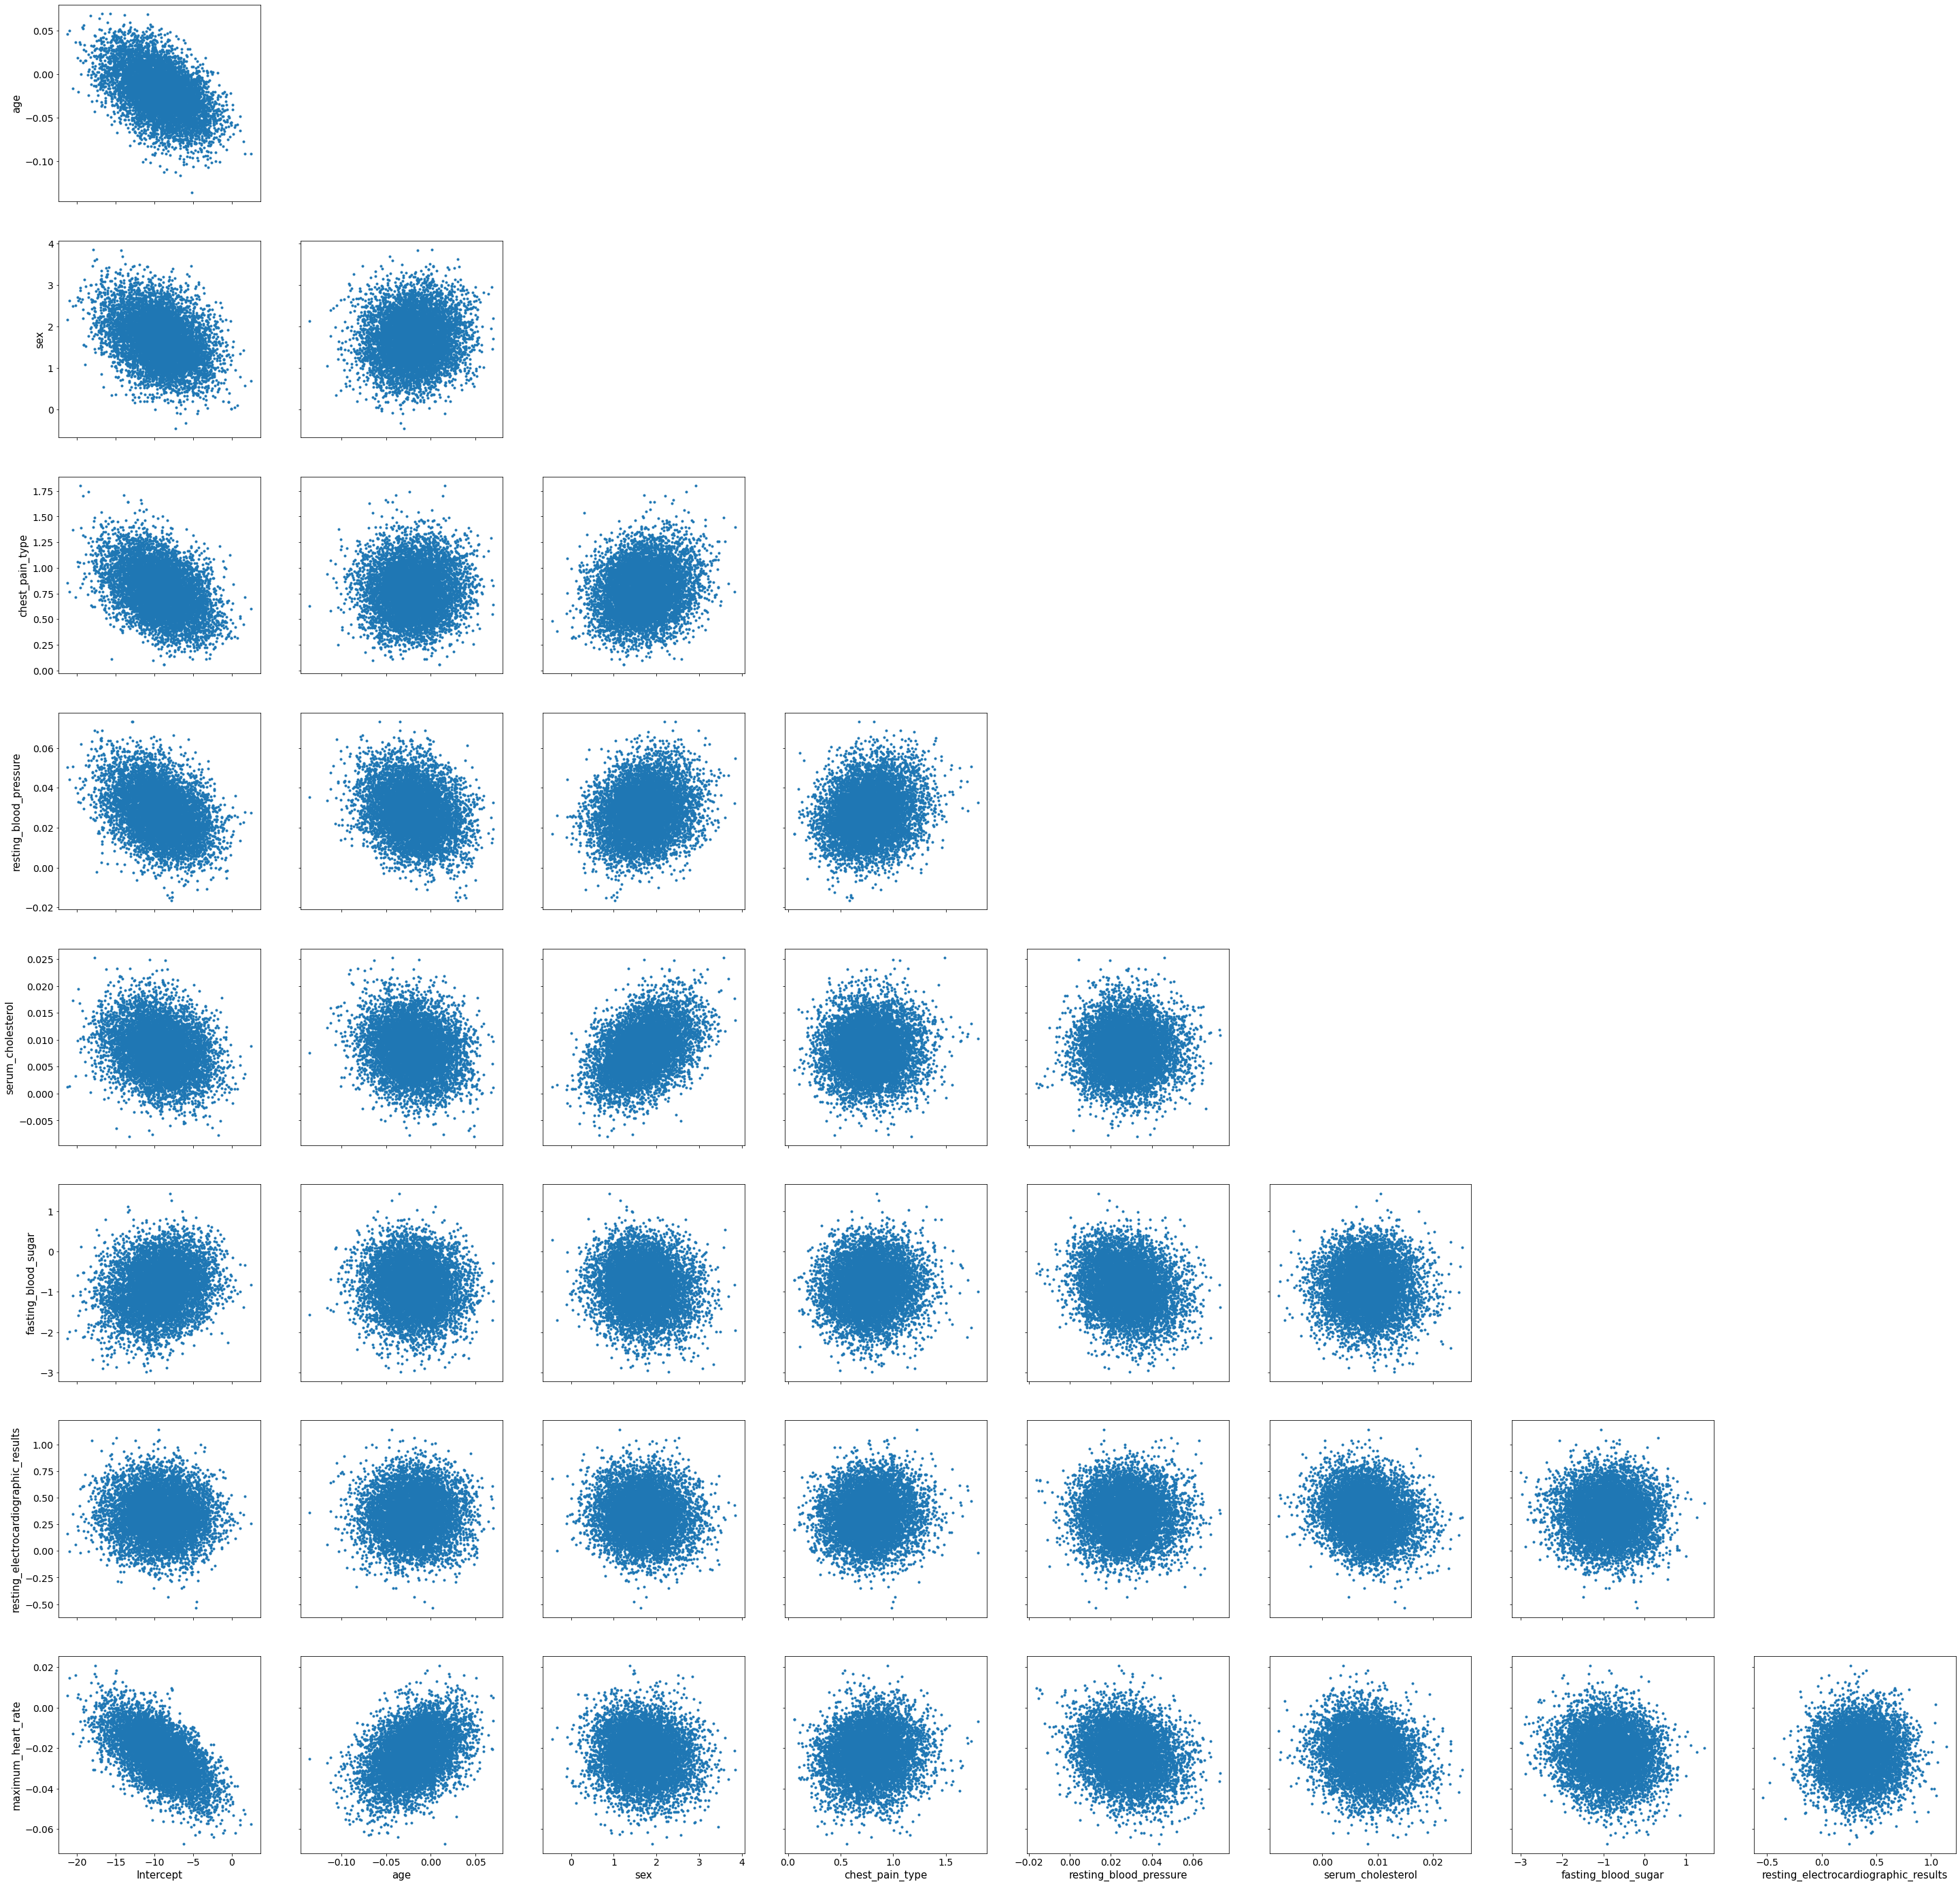

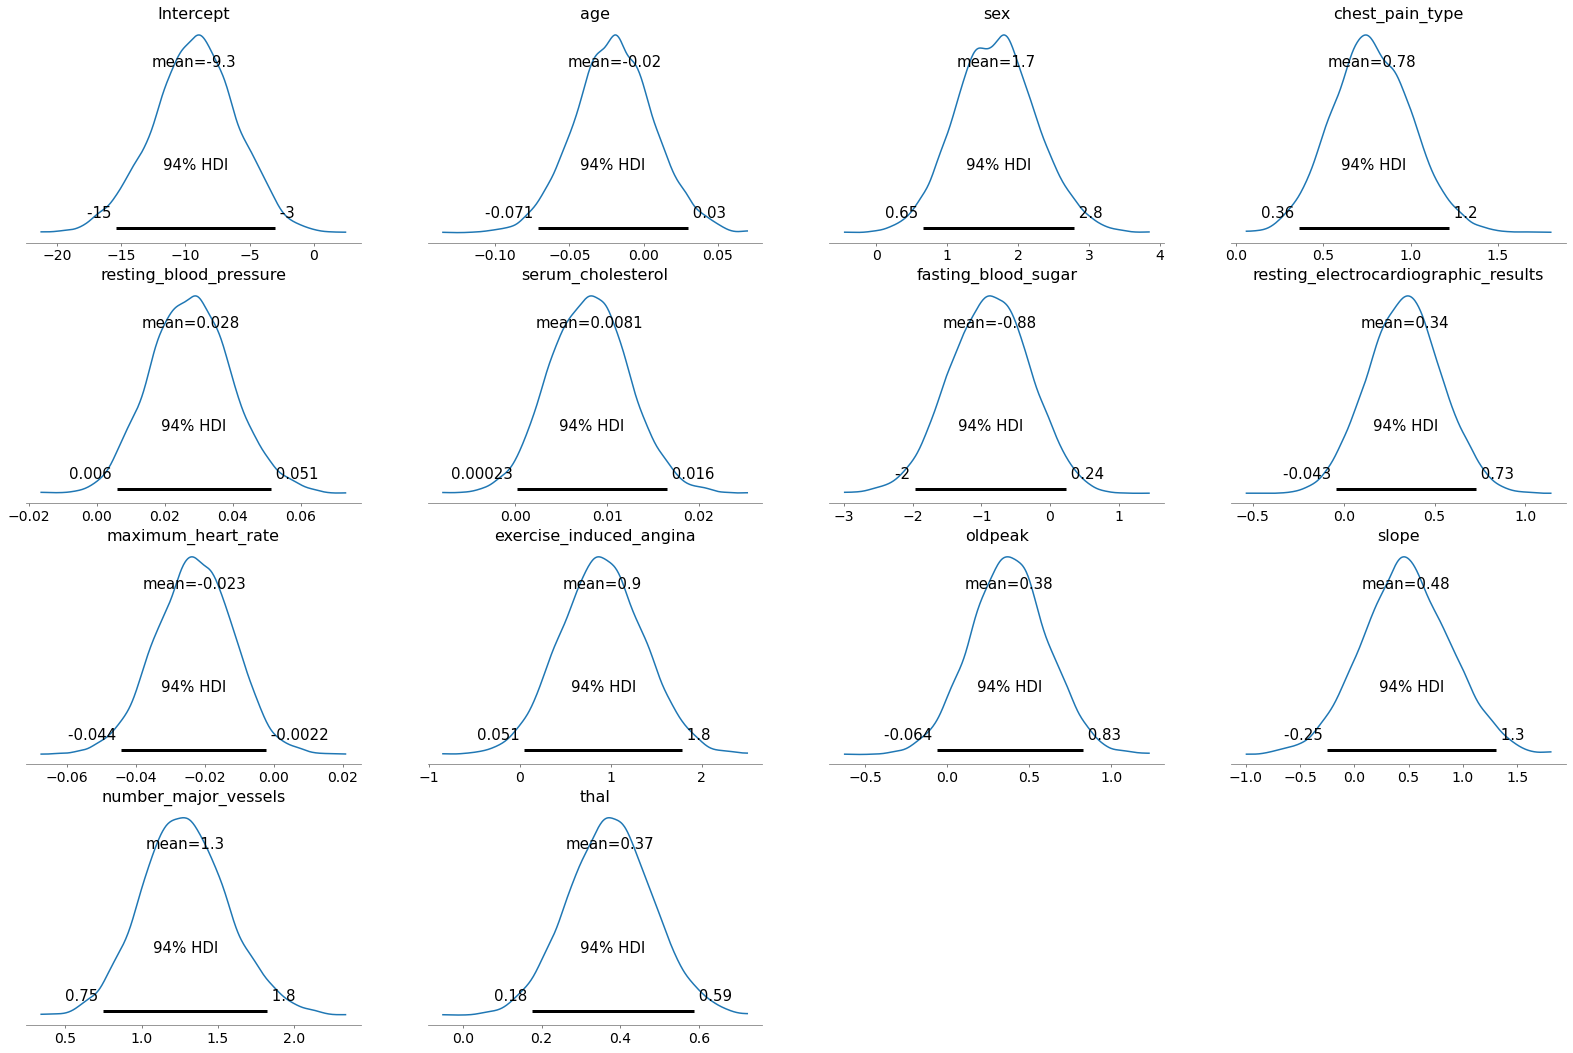

In [ ]:
with logistic_model:
  az.plot_pair(trace, figsize=(50, 50))
  pm.plot_posterior(trace)

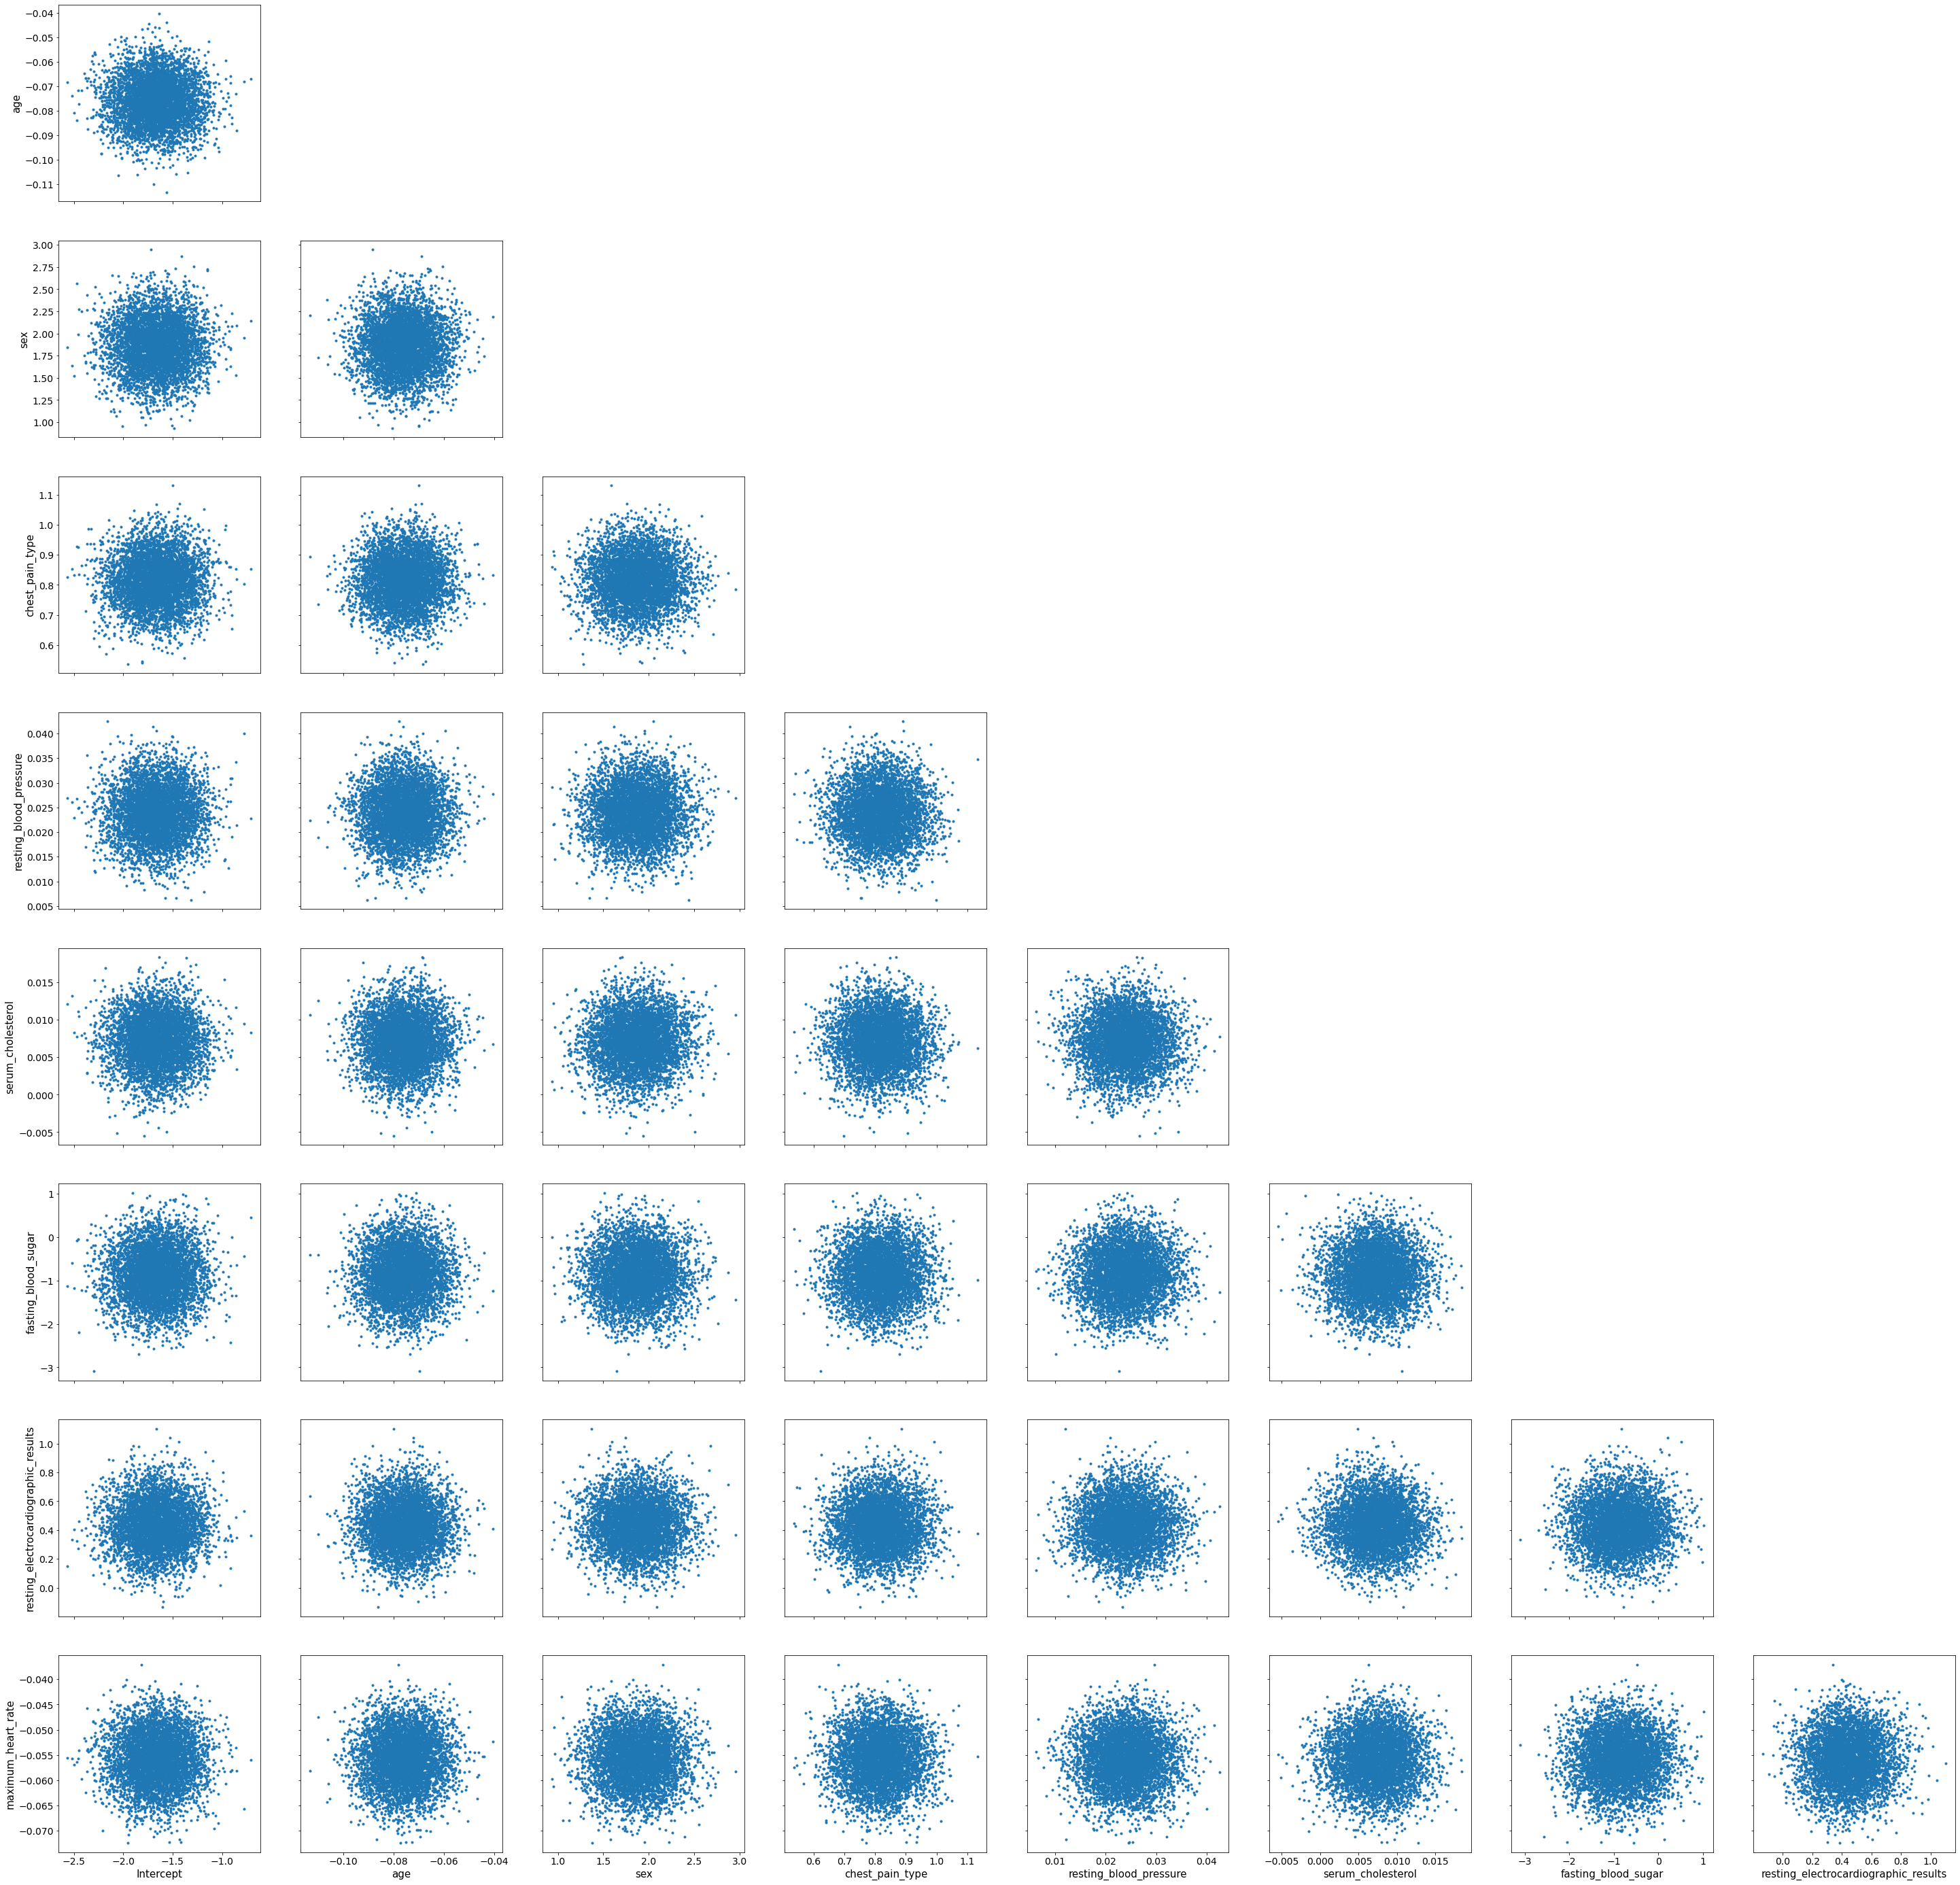

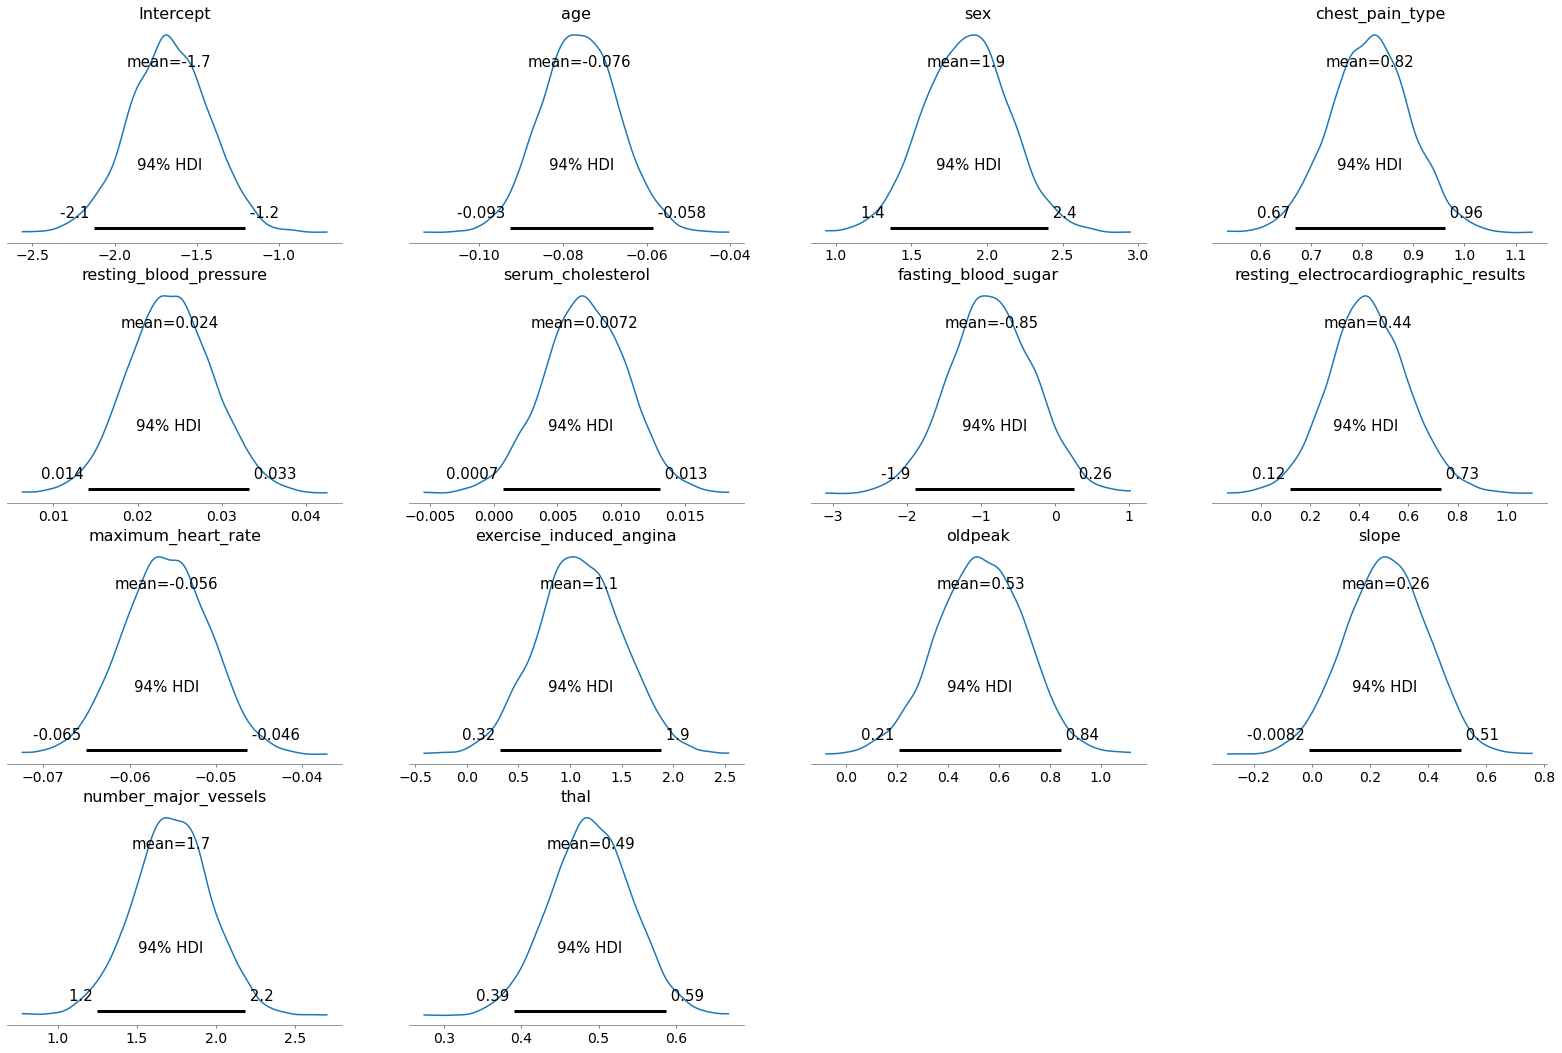

In [ ]:
with logistic_model:
  az.plot_pair(trace_advi, figsize=(50, 50))
  pm.plot_posterior(trace_advi)

In [ ]:
parameter_3=None
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute',tolerance=2e-4)
    approx = pm.fit(n=10000, callbacks=[callback], obj_n_mc=10,
               obj_optimizer=pm.adagrad(learning_rate=0.05),method='fullrank_advi')

Finished [100%]: Average Loss = 218.65


In [ ]:
with logistic_model:  
    trace_advi = approx.sample(5000)
    display(pm.summary(trace_advi))
    parameter_3=pm.summary(trace_advi)["mean"]

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


mean     sd  ...  ess_tail  r_hat
Intercept                            -0.663  1.670  ...    4754.0    NaN
age                                  -0.065  0.025  ...    4826.0    NaN
sex                                   1.359  0.559  ...    4094.0    NaN
chest_pain_type                       0.618  0.217  ...    4895.0    NaN
resting_blood_pressure                0.019  0.011  ...    4408.0    NaN
serum_cholesterol                     0.006  0.004  ...    4264.0    NaN
fasting_blood_sugar                  -0.701  0.607  ...    5025.0    NaN
resting_electrocardiographic_results  0.364  0.204  ...    4555.0    NaN
maximum_heart_rate                   -0.046  0.010  ...    4984.0    NaN
exercise_induced_angina               0.874  0.461  ...    4545.0    NaN
oldpeak                               0.435  0.243  ...    4698.0    NaN
slope                                 0.132  0.414  ...    4229.0    NaN
number_major_vessels                  1.413  0.290  ...    4712.0    NaN
thal                                  0.394  0.119  ...    4865.0    NaN

[14 rows x 9 columns]

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


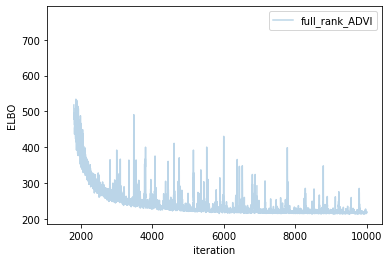

In [ ]:
with logistic_model:
    plt.plot(approx.hist, label="full_rank_ADVI", alpha=0.3)
    plt.legend()
    plt.ylabel("ELBO")
    plt.xlabel("iteration")

In [ ]:
prediction_and_evaluation(parameters,X,Y)

0.8555555555555555

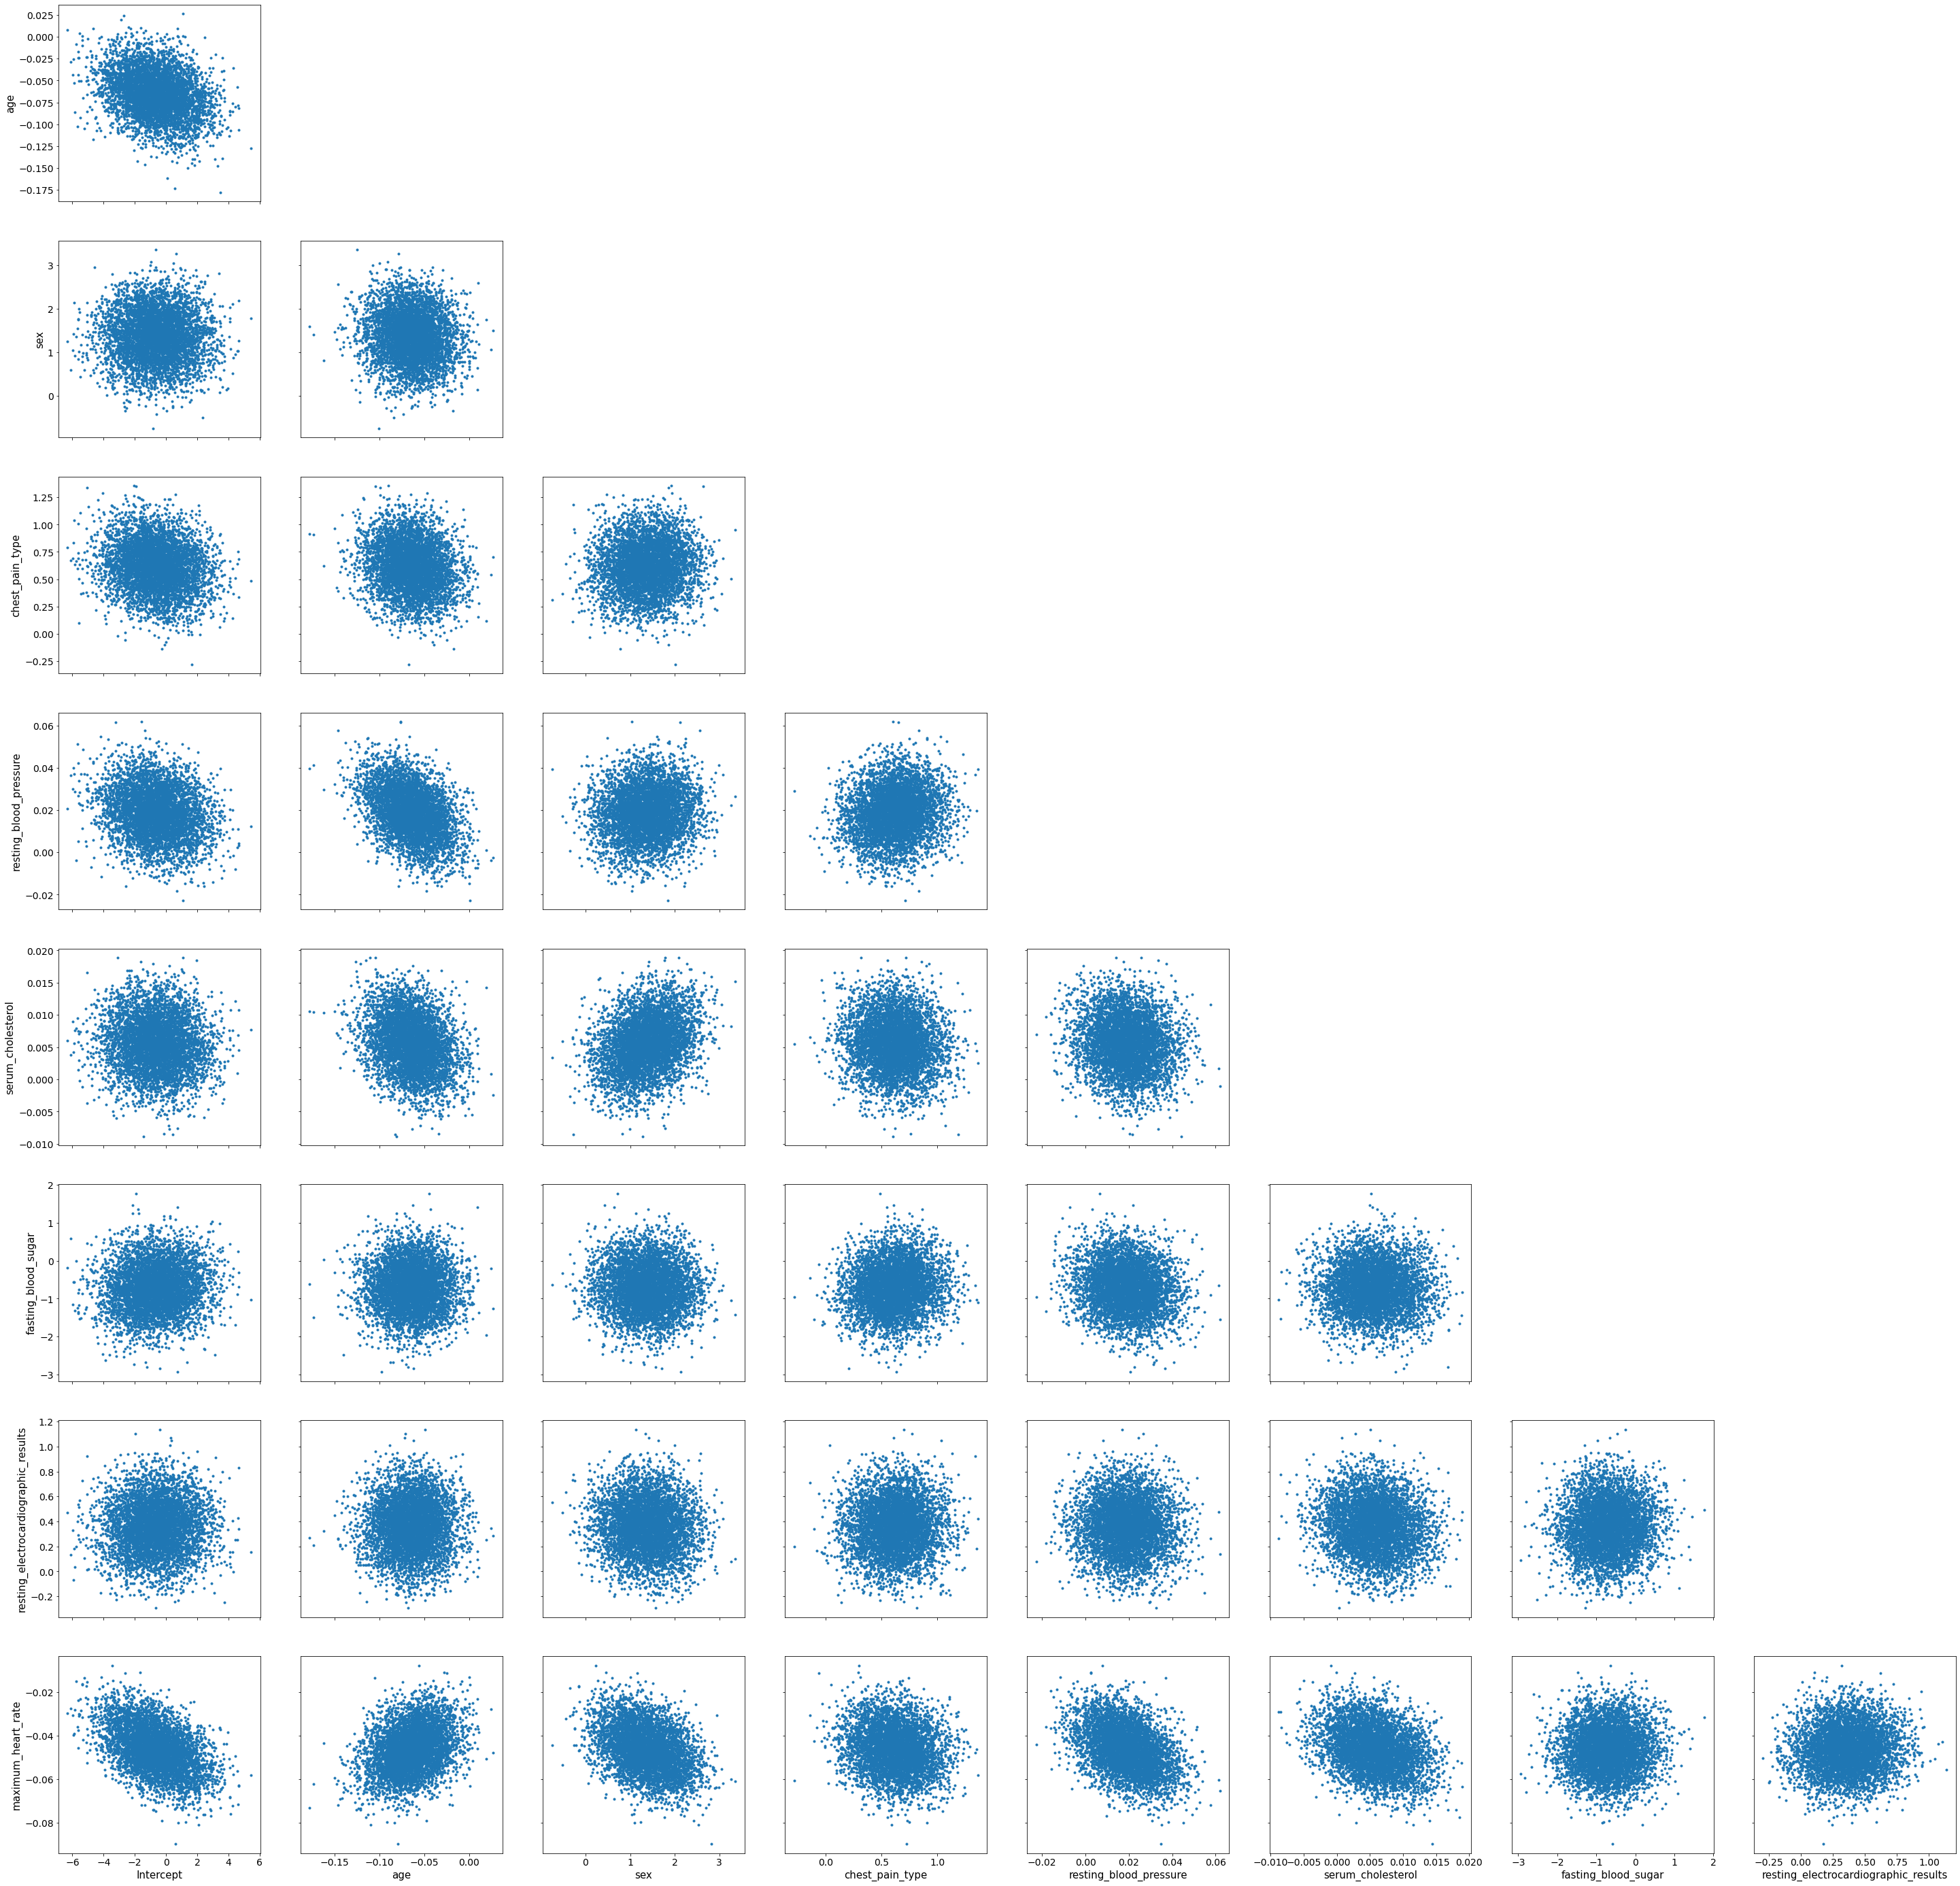

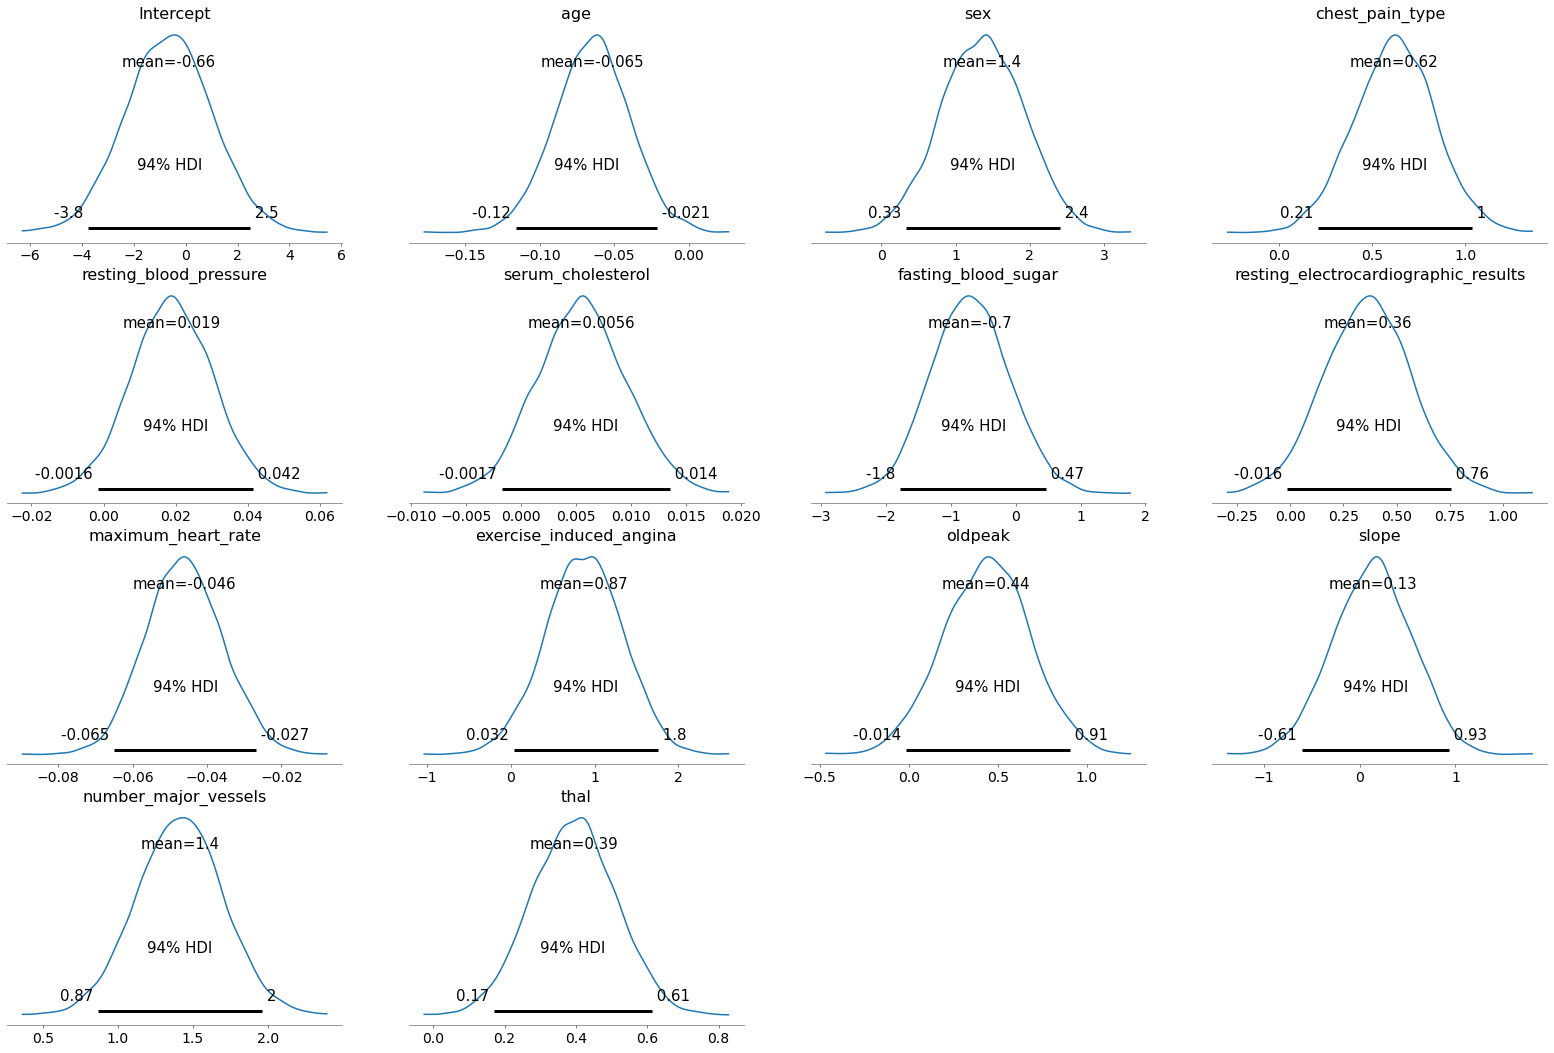

In [ ]:
with logistic_model:
  az.plot_pair(trace_advi, figsize=(50, 50))
  pm.plot_posterior(trace_advi)

Belows are interesting experiments that I did to examine the differences between ADVI and MCMC.  

In [ ]:
def _get_bounds(samples):
    """Helper function to draw consistent bounds"""
    x_max, y_max = 0, 0
    for x_draws, y_draws in samples.values():
        x_max = max(x_max, np.abs(x_draws).max())
        y_max = max(y_max, np.abs(y_draws).max())
    top = max(x_max, y_max)
    return (-top, top)


def density_model(Ω):
    """This is the "modeling" step.  
    
    We are using PyMC3, and assuming we get an object Ω that represents some joint
    distribution. We require Ω to have two methods: `logp` and `random`. The logp should also
    be defined in a Theano-compatible fashion so it can compute the gradients.
    """
    with pm.Model() as model:
        omega = pm.DensityDist('Ω', Ω.logp, shape=2)
    return model

def sampler(Ω, N=1000):
    """This is the "inference" step
    
    Note that the only added difficulty in using ADVI is that we have a call to `pm.fit` in order to learn
    the parameters for the mean-field or full-rank approximation.
    """
    samples = {'Ground Truth': Ω.random(size=N).T}
    with density_model(Ω):
        samples['NUTS'] = pm.sample(N, step=pm.NUTS(), chains=1)['Ω'].T
        
        for method in ('advi', 'fullrank_advi'):
            inference = pm.fit(n=30000, method=method)
            samples[method] = inference.sample(N)['Ω'].T
            
    return samples


def plotter(samples):
    """Helper to plot the output of `sampler`.  A little flexible in case we want to add more VI methods.
    """
    size = int(np.ceil(len(samples) ** 0.5))
    fix, axs = plt.subplots(size, size, figsize=(12, 8))
    bounds = _get_bounds(samples)
    for (label, (x, y)), ax in zip(samples.items(), axs.ravel()):
        ax.plot(x, y, 'o', alpha = 0.5)
        ax.set_title(label)
        ax.axes.set_xlim(bounds)
        ax.axes.set_ylim(bounds)
        

def sample_and_plot(dist):
    """For the lazy"""
    samples = sampler(dist)
    plotter(samples)

class MoG(object):
    def __init__(self, centers, sds):
        mu_1, mu_2 = centers
        cov_1 = tt.as_tensor([[sds[0], 0], [0, sds[0]]])
        cov_2 = tt.as_tensor([[sds[1], 0], [0, sds[1]]])

        self.rvs = [pm.MvNormal.dist(mu=mu_1, cov=cov_1, shape=2),
                    pm.MvNormal.dist(mu=mu_2, cov=cov_2, shape=2)]
        
    def random(self, size=1):
        return np.array([rv.random() for rv in np.random.choice(self.rvs, size=size)])
    
    def logp(self, value):
        return pm.math.logsumexp([rv.logp(value) for rv in self.rvs]) - np.log(len(self.rvs))

Ill-conditioned Gaussian: small change in input(probabaly due to error), drastic change in the output.

In [ ]:
mu = tt.zeros(2,)
cov = tt.as_tensor([[1e-2, 0.], [0., 1e2]])
Ω = pm.MvNormal.dist(mu=mu, cov=cov, shape=2, testval=mu)

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Finished [100%]: Average Loss = 0.090541


Finished [100%]: Average Loss = 0.052756


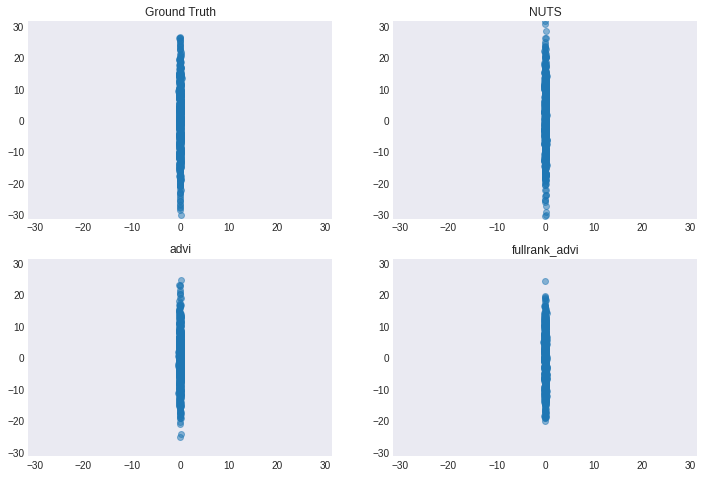

In [ ]:
sample_and_plot(Ω)


Data are generated by a strongly correlated gaussian distribution.

In [ ]:
mu = tt.zeros(2,)
cov = tt.as_tensor([[50.05, -49.95], [-49.95, 50.05]])
Ω = pm.MvNormal.dist(mu=mu, cov=cov, shape=2, testval=mu)

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Finished [100%]: Average Loss = 2.723


Finished [100%]: Average Loss = 0.8452


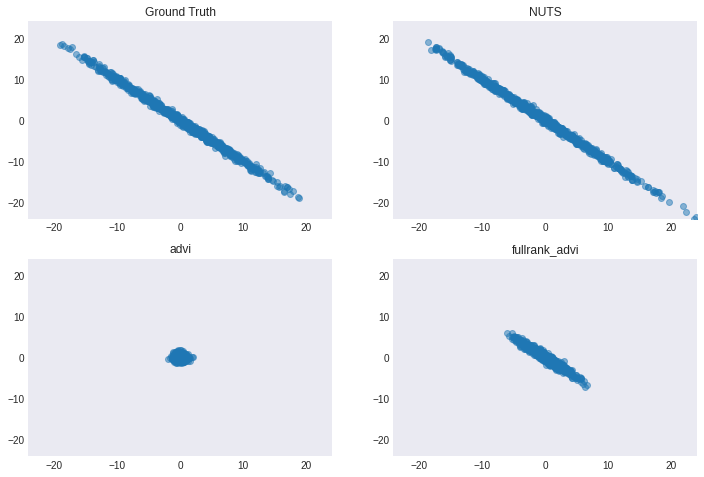

In [ ]:
sample_and_plot(Ω)

Mixture of Gaussians: In practice, the posterior distribution might be generated by a complex mixture of the Gaussian distributions. We will see how ADVI and MCMC works here. 

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Finished [100%]: Average Loss = 6.1416


Finished [100%]: Average Loss = 6.144


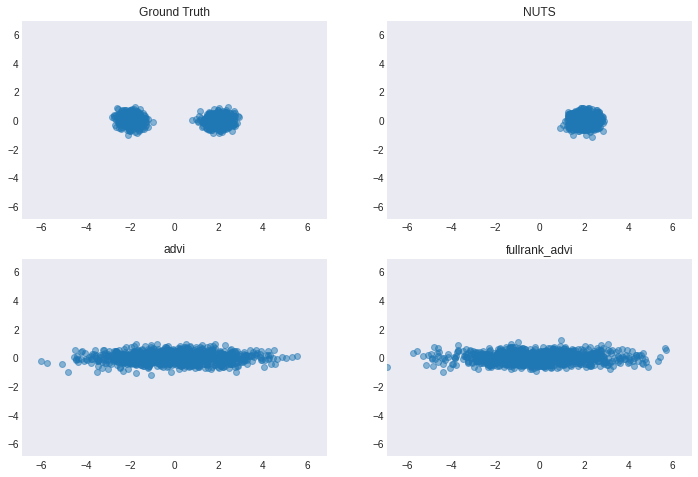

In [ ]:
Ω = MoG(centers=[np.array([-2, 0]), np.array([2, 0])], sds=[0.1, 0.1])
sample_and_plot(Ω)

Mixture of Gaussians with different scales

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Finished [100%]: Average Loss = 0.70334


Finished [100%]: Average Loss = 0.70533


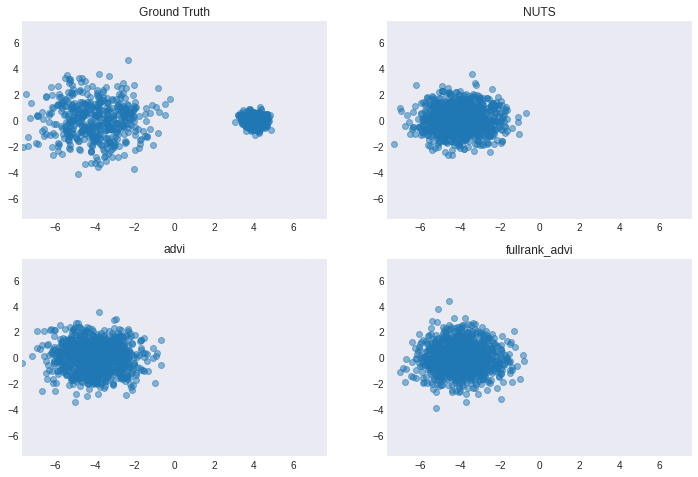

In [ ]:
Ω = MoG(centers=[np.array([-4, 0]), np.array([4, 0])], sds=[2, 0.1])
sample_and_plot(Ω)

 Mixture of non-axis-aligned Gaussians

Sequential sampling (1 chains in 1 job)
NUTS: [Ω]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Finished [100%]: Average Loss = 1.4603


Finished [100%]: Average Loss = 6.2162


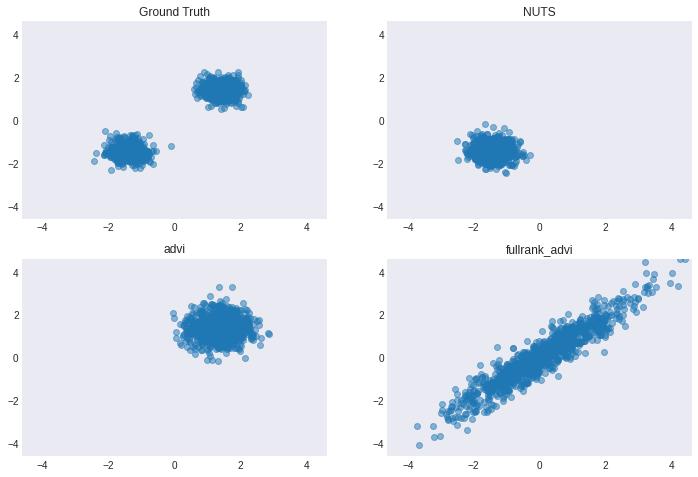

In [ ]:
θ = np.pi / 4
rot_45 = np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])
Ω = MoG(centers=[rot_45.dot(np.array([-2, 0])), rot_45.dot(np.array([2, 0]))], sds=[0.1, 0.1])

sample_and_plot(Ω)